In [1]:
%matplotlib inline

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy.ndimage.filters import gaussian_filter

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")

DATA = "data/fig8-aln+thalamus_bifurcation"
FR_THRESH = 0.5


def norm_ou_mu(da):
    da["ou_exc_mu"] = da["ou_exc_mu"] / 5.0
    da["ou_inh_mu"] = da["ou_inh_mu"] / 5.0
    return da

In [2]:
def plot_imshow(
    array,
    contour_with=None,
    title="",
    xdim="thalamus-AdEx",
    ydim="AdEx-thalamus",
    cbar_label="",
    log_colors=False,
    symmetric_around=None,
    cmap="plasma",
    custom_log_ticks=None,
    subplot_str=None,
):
    fig, axes = plt.subplots(
        len(array[ydim]),
        len(array[xdim]),
        sharex=True,
        sharey=True,
        figsize=(11, 11),
    )
    vmin = array.min().values
    vmax = array.max().values
    if symmetric_around is not None:
        assert isinstance(symmetric_around, (float, int))
        if log_colors:
            assert symmetric_around == 1.0
            maxi_ = np.amax([np.abs(np.log10(vmin)), np.log10(vmax)])
            vmin = np.power(10, -maxi_)
            vmax = np.power(10, maxi_)
        else:
            maxi_ = np.amax([(symmetric_around - vmin), (vmax - symmetric_around)])
            vmin = symmetric_around - maxi_
            vmax = symmetric_around + maxi_

    plt.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.09, top=0.93)
    # reverse this to make 0,0 at lower left
    for ii, adth in enumerate(array[ydim][::-1]):
        for jj, thad in enumerate(array[xdim]):
            ax = axes[ii, jj]
            field = array.sel({ydim: adth.values, xdim: thad.values}).transpose().values
            if (contour_with is not None) and (adth == 0.0) and (thad == 0.0):
                contour = contour_with.sel({ydim: adth.values, xdim: thad.values})
                blurred = gaussian_filter(contour.values, 0.0)
                blurred[blurred < FR_THRESH] = 0
                blurred[blurred >= FR_THRESH] = 1
            ax.imshow(
                field,
                origin="lower",
                cmap=cmap,
                vmin=vmin if not log_colors else None,
                vmax=vmax if not log_colors else None,
                norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax) if log_colors else None,
                extent=[
                    array["ou_exc_mu"].min(),
                    array["ou_exc_mu"].max(),
                    array["ou_inh_mu"].min(),
                    array["ou_inh_mu"].max(),
                ],
            )
            if (contour_with is not None) and (adth == 0.0) and (thad == 0.0):
                xi, yi = np.meshgrid(array["ou_exc_mu"], array["ou_inh_mu"])
                ax.contour(
                    xi,
                    yi,
                    contour.T,
                    colors="white",
                    linestyles="solid",
                    levels=[0, 1.0001],
                    linewidths=(6,),
                    zorder=1,
                )
            ax.set_title("")
            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            if adth == array[ydim].min():
                ax.set_xlabel(f"{thad.values}")
            if thad == array[xdim].min():
                ax.set_ylabel(f"{adth.values}")

    ydim_txt = r"ALN $\to$ thalamus"
    fig.text(0.04, 0.55, ydim_txt, va="center", rotation="vertical", size=22)
    xdim_txt = r"thalamus $\to$ ALN"
    fig.text(0.5, 0.05, xdim_txt, va="center", ha="center", size=22)
    # bottom arrow
    conn = mpl.patches.ConnectionPatch(
        (0.2, 0.065),
        (0.8, 0.065),
        coordsA="figure fraction",
        coordsB="figure fraction",
        arrowstyle="-|>",
        color="k",
        linewidth=2.5,
        mutation_scale=30.0,
    )
    fig.add_artist(conn)
    # left arrow
    conn = mpl.patches.ConnectionPatch(
        (0.08, 0.2),
        (0.08, 0.8),
        coordsA="figure fraction",
        coordsB="figure fraction",
        arrowstyle="-|>",
        color="k",
        linewidth=2.5,
        mutation_scale=30.0,
    )
    fig.add_artist(conn)
    plt.suptitle(title)
    cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.02])
    if log_colors:
        norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        formatter = mpl.ticker.LogFormatter(10, labelOnlyBase=False)
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        formatter = None
    cbar = mpl.colorbar.ColorbarBase(
        cbar_ax,
        cmap=plt.get_cmap(cmap),
        norm=norm,
        format=formatter,
        orientation="horizontal",
    )
    if log_colors and custom_log_ticks:
        assert isinstance(custom_log_ticks, (list, tuple))
        cbar.ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(custom_log_ticks))
        cbar.ax.xaxis.set_ticklabels(custom_log_ticks, minor=False)
        cbar.ax.xaxis.set_ticks([], minor=True)
    cbar.set_label(cbar_label)
    if subplot_str is not None:
        plt.text(
            0.5,
            1.0,
            subplot_str,
            ha="center",
            va="center",
            transform=fig.transFigure,
            fontsize=50,
        )


def plot_reference(array, noise=0, contour=None, log_cols=False):
    axins_col = "w"
    sels = {
        "noise": noise,
        "AdEx-thalamus": 0.0,
        "thalamus-AdEx": 0.0,
    }

    array = array.sel(sels)

    plt.figure(figsize=(7.5, 3.3))
    vmin = array.min().values
    vmax = array.max().values
    extent = [
        array["ou_exc_mu"].min(),
        array["ou_exc_mu"].max(),
        array["ou_inh_mu"].min(),
        array["ou_inh_mu"].max(),
    ]
    plt.imshow(
        array.T,
        origin="lower",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax) if log_cols else None,
    )

    if contour is not None:
        contour = contour.sel(sels)
        xi, yi = np.meshgrid(array["ou_exc_mu"], array["ou_inh_mu"])
        plt.gca().contour(
            xi,
            yi,
            contour.T,
            colors="white",
            linestyles="solid",
            levels=[0, 1.0001],
            linewidths=(8,),
            zorder=1,
        )
    plt.xlabel("Input to E [nA]")
    plt.ylabel("Input to I [nA]")
    axins = plt.gca().inset_axes([0.9, 0.9, 0.4, 0.4])
    axins.imshow(
        array.T,
        extent=extent,
        origin="lower",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
        norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax) if log_cols else None,
    )
    if contour is not None:
        axins.contour(
            xi,
            yi,
            contour.T,
            colors=axins_col,
            linestyles="solid",
            levels=[0, 1.0001],
            linewidths=(5,),
            zorder=1,
        )
    # sub region of the original image
    x1, x2, y1, y2 = 0.4, 1, 0.4, 1
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([0.4, 1.0])
    axins.set_yticks([0.4, 1.0])
    label = axins.xaxis.get_ticklabels()[0]
    label.set_color(axins_col)
    label = axins.yaxis.get_ticklabels()[0]
    label.set_color(axins_col)
    axins.set_aspect("auto")

    plt.gca().indicate_inset_zoom(
        axins, ec=axins_col, alpha=1.0, fc="none", linewidth=2.0
    )

In [3]:
subsample_conns = {
    "AdEx-thalamus": slice(None, None, 2),
    "thalamus-AdEx": slice(None, None, 2),
}

aln_domfr = xr.open_dataarray(os.path.join(DATA, "adex_domfr.nc")).isel({"time": 0})
aln_domfr = norm_ou_mu(aln_domfr)
aln_domfr = aln_domfr.sel(subsample_conns)

aln_ampdiff = xr.open_dataarray(os.path.join(DATA, "adex_amp_diff.nc")) * 1000.0
aln_ampdiff = norm_ou_mu(aln_ampdiff)
aln_ampdiff = aln_ampdiff.sel(subsample_conns)

aln_spectral = xr.open_dataarray(os.path.join(DATA, "spectral_power.nc"))
aln_spectral = norm_ou_mu(aln_spectral)
aln_spectral = aln_spectral.sel(subsample_conns)

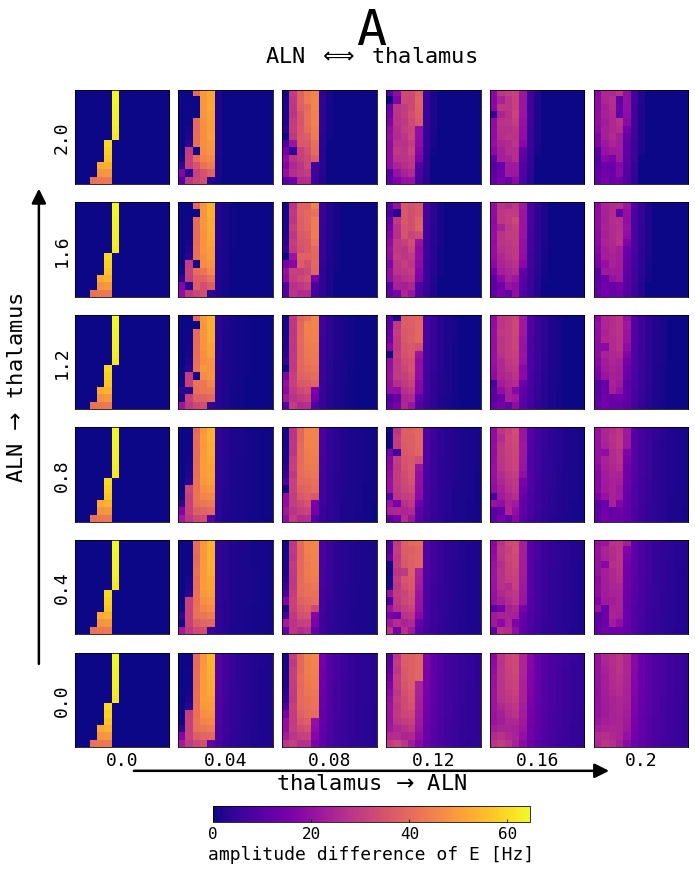

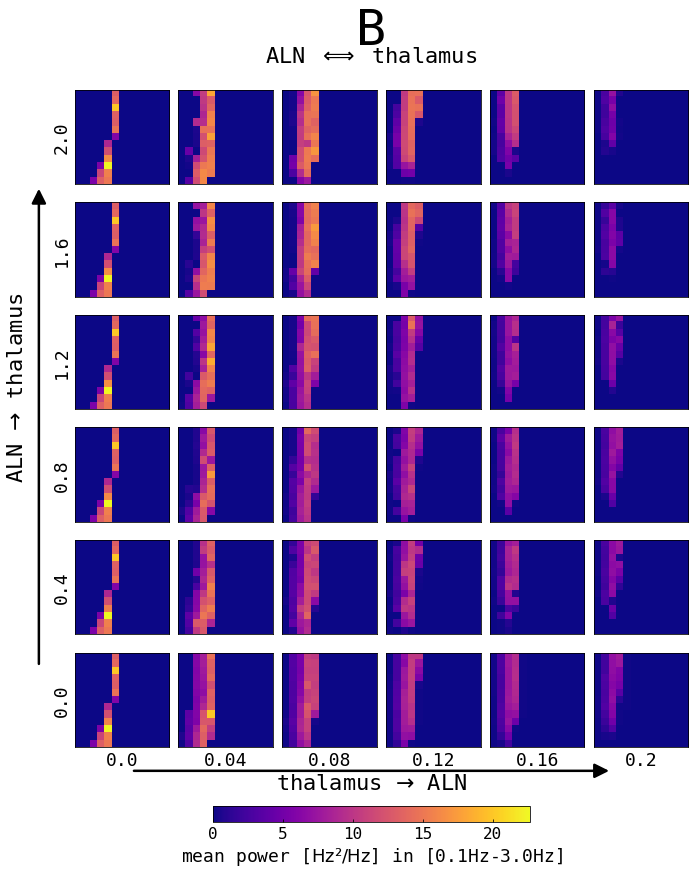

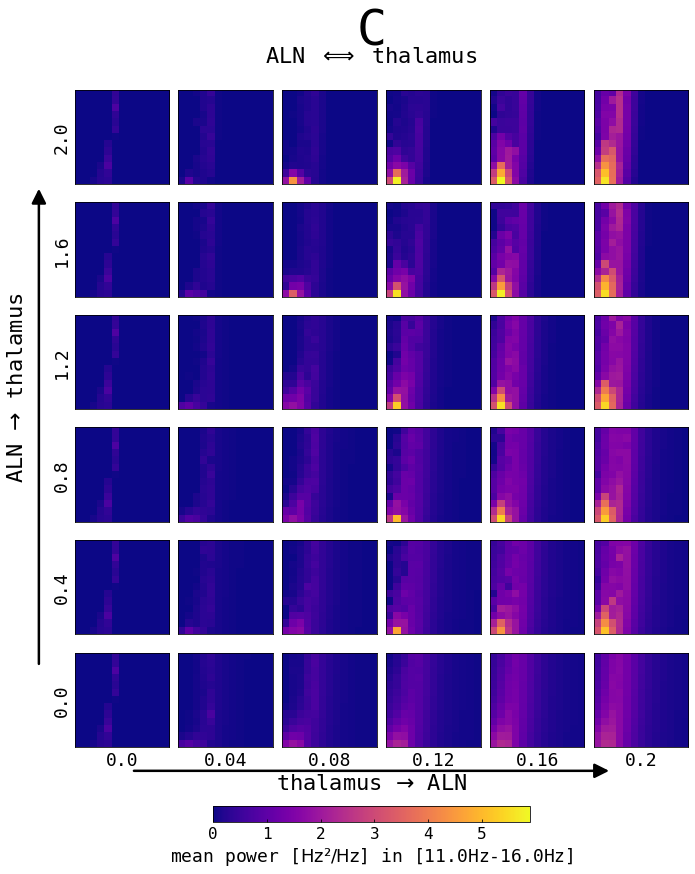

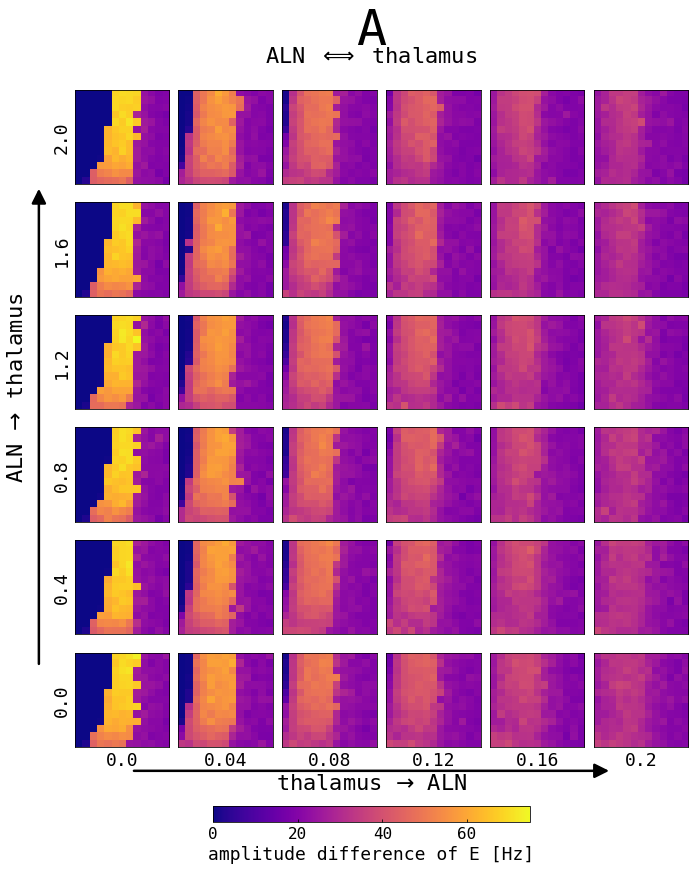

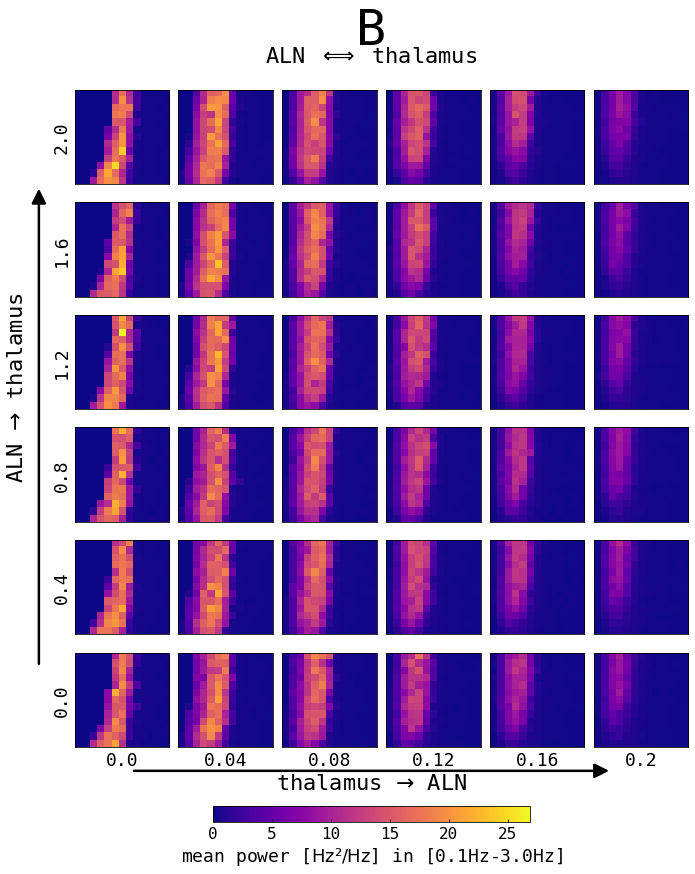

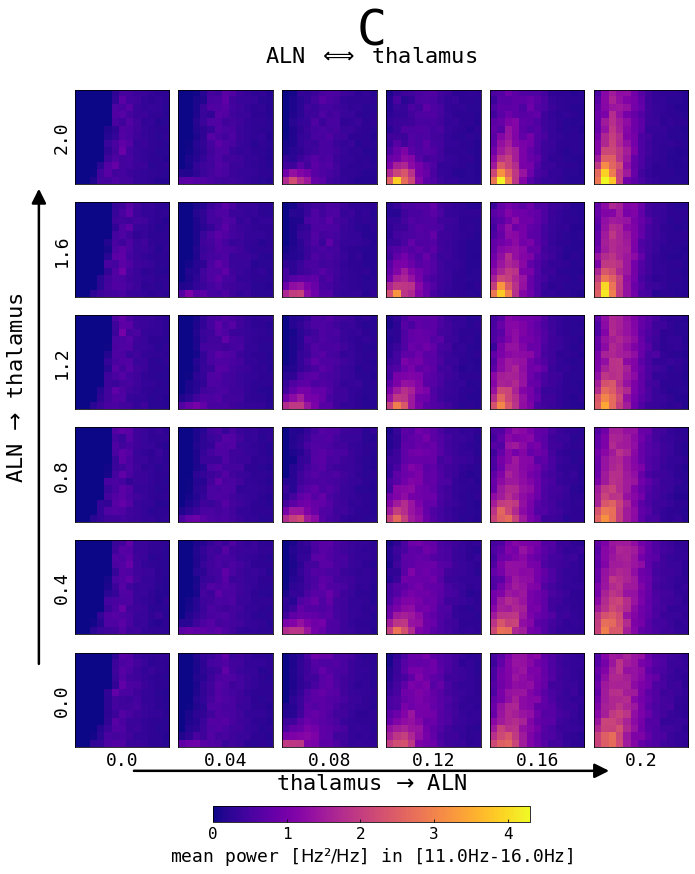

In [4]:
params = [0, 1]
subplot_strs = ["B", "C"]

for noise in params:

    aln_n = 0.0 if noise == 0 else 0.05
    tcr_n = 0.0 if noise == 0 else 0.005

    sels = {
        "noise": noise,
        "ou_exc_mu": slice(0.4, None),
        "ou_inh_mu": slice(0.4, None),
    }
    plot_imshow(
        aln_ampdiff.sel(sels),
        contour_with=None,
        cbar_label="amplitude difference of E [Hz]",
        # title=f"ALN $\\Longleftrightarrow$ thalamus \n $\\sigma_{{ALN}}$={aln_n}, "
        # f"$\\sigma_{{TCR}}$={tcr_n}",
        title=f"ALN $\\Longleftrightarrow$ thalamus",
        subplot_str="A",
    )
    plt.savefig(
        f"../figs/aln_bif_loop_ampdiff_aln_sig{aln_n}_tcr_sig{tcr_n}.pdf",
        dpi=DPI,
        bbox_inches="tight",
        transparent=True,
    )
    for ii, freq in enumerate(aln_spectral["frequency"]):
        plot_imshow(
            aln_spectral.sel({**sels, "frequency": freq, "node": 0.0}),
            cbar_label=freq.values,
            # title=f"ALN $\\Longleftrightarrow$ thalamus \n $\\sigma_{{ALN}}$={aln_n}, "
            # f"$\\sigma_{{TCR}}$={tcr_n}",
            title=f"ALN $\\Longleftrightarrow$ thalamus",
            subplot_str=subplot_strs[ii],
        )
        plt.savefig(
            f"../figs/aln_bif_loop_{str(freq.values)[35:-1]}_mean_pow_aln_sig{aln_n}_tcr_sig{tcr_n}.pdf",
            dpi=DPI,
            bbox_inches="tight",
            transparent=True,
        )

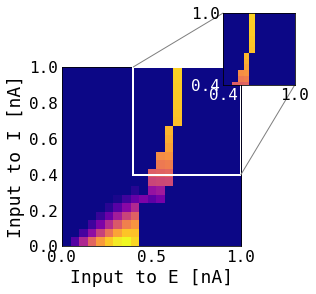

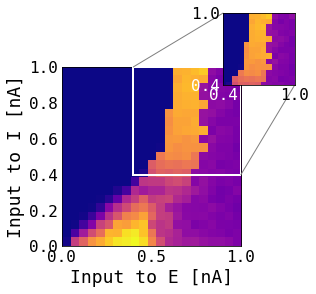

In [5]:
for noise, (aln_n, tcr_n) in enumerate([(0.0, 0.0), (0.05, 0.005)]):
    plot_reference(aln_ampdiff, noise=noise, contour=None)
    plt.savefig(
        f"../figs/aln_bif_loop_ampdiff_aln_sig{aln_n}_tcr_sig{tcr_n}_reference.pdf",
        dpi=DPI,
        bbox_inches="tight",
        transparent=True,
    )